In [31]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

## Import Data

In [32]:
data_df = pd.read_csv('../data/processed/merged_data.csv')
data_df_sales = pd.read_csv('../data/electricity/retail_sales.csv')

## Format Data

In [33]:
data_df_sales = data_df_sales.iloc[:,[1] + list(range(4,16))]

month_dict = dict(zip(data_df_sales.columns[1:16], range(1,13)))

data_df_sales = data_df_sales.melt(id_vars = 'State Name', var_name = 'month_name', value_name = 'net_sales_elc_all')

In [34]:
# fix cols
data_df_sales['month'] = data_df_sales['month_name'].apply(lambda x: month_dict.get(x))
data_df_sales['State Name'] = data_df_sales['State Name'].str.upper()

In [35]:
data_df = data_df_sales.merge(data_df, on = ['State Name', 'month'])

## Regress

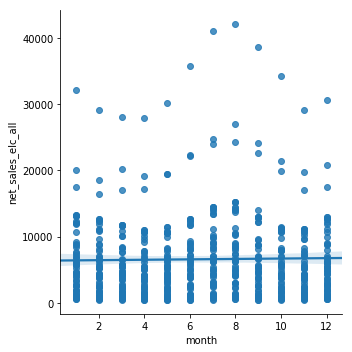

In [36]:
sns.lmplot(x = 'month', y = 'net_sales_elc_all', data = data_df)

Find relative values of quantity and price: $Y(t_i) \, / \, Y(t_1)$ and $p(t_i) \, / \, p(t_1)$ in each state

In [37]:
data_temp = data_df.query('month == 1').groupby(['State FIPS']).first().reset_index()
data_temp = data_temp[['State FIPS', 'net_sales_elc_all', 'elc_price_all']].rename(
    columns = {'net_sales_elc_all': 'nsea_m1', 'elc_price_all': 'epa_m1'})

data_temp2 = data_df.groupby(['State FIPS']).mean().reset_index()
data_temp2 = data_temp2[['State FIPS', 'net_sales_elc_all']].rename(columns = {'net_sales_elc_all': 'nsea_avg'})

In [38]:
data_df = data_df.merge(data_temp, on = 'State FIPS').merge(data_temp2, on = 'State FIPS')

data_df['nsea_rel'] = np.divide(data_df['net_sales_elc_all'], data_df['nsea_m1'])
data_df['nsea_dmd'] = np.subtract(data_df['net_sales_elc_all'], data_df['nsea_avg'])

data_df['epa_rel'] = np.divide(data_df['elc_price_all'], data_df['epa_m1'])

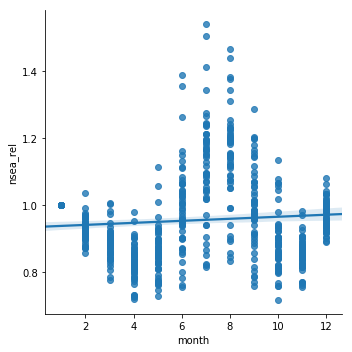

In [39]:
sns.lmplot(x = 'month', y = 'nsea_rel', data = data_df)

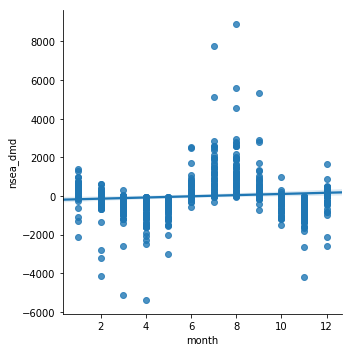

In [40]:
sns.lmplot(x = 'month', y = 'nsea_dmd', data = data_df)

In [41]:
data_df.to_csv('../data/processed/elasticity_data.csv', index = False)

### Alpha Estimation

In [42]:
import scipy as sp
import matplotlib.pyplot as plt

In [43]:
def sin_f(x, a, b, c, d):
    return np.sin(x*a + b)*c + d

In [44]:
popt, pcov = sp.optimize.curve_fit(sin_f, data_df['month'], data_df['nsea_rel'])

In [45]:
popt

array([0.86802217, 1.50031627, 0.12593801, 0.97062296])

In [31]:
def sin_f_fitted(x):
    return sin_f(x, popt[0], popt[1], popt[2], popt[3])

In [32]:
fit_result = []

for x in range(0,13):
    fit_result.append([x, sin_f_fitted(x)])

In [33]:
data_df_fit = pd.DataFrame(fit_result)
data_df_fit.rename(columns = {0: 'month', 1: 'fitted'}, inplace = True)

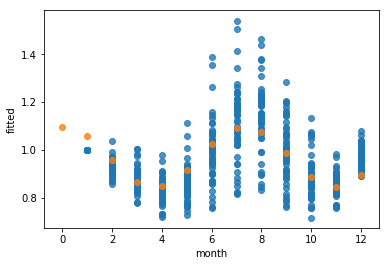

In [34]:
ax = sns.regplot(x = 'month', y = 'nsea_rel', data = data_df, fit_reg=False)
sns.regplot(x = 'month', y = 'fitted', data = data_df_fit, ax = ax, fit_reg=False)

In [35]:
data_df['fitted_sin_nsea'] = data_df['month'].apply(sin_f_fitted)

In [36]:
data_df['state_name'] = data_df['State Name']

In [37]:
res = smf.ols('nsea_rel ~ fitted_sin_nsea:state_name + CDD + HDD -1', data = data_df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               nsea_rel   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2227.
Date:                Wed, 29 Aug 2018   Prob (F-statistic):               0.00
Time:                        11:49:26   Log-Likelihood:                 789.80
No. Observations:                 624   AIC:                            -1478.
Df Residuals:                     573   BIC:                            -1251.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
fitted_sin_nsea:state_name[ALABAMA]            0.9355      0.022     42.051      0.000       0.892       0.979
fitted_sin_nsea:state_name[ALASKA]             0.6467      0.032     20.131      0.000       0.584       0.710
fitted_sin_nsea:state_name[ARIZONA]            1.0735      0.023     47.259      0.000       1.029       1.118
fitted_sin_nsea:state_name[ARKANSAS]           0.9728      0.022     43.903      0.000       0.929       1.016
fitted_sin_nsea:state_name[CALIFORNIA]         1.0778      0.022     49.687      0.000       1.035       1.120
fitted_sin_nsea:state_name[COLORADO]           0.9985      0.022     45.977      0.000       0.956       1.041
fitted_sin_nsea:state_name[CONNECTICUT]        0.9500      0.022     43.469      0.000       0.907       0.993
fitted_sin_nsea:state_name[DELAWARE]           0.9396      0.022     42.757      0.000       0.896       0.983
fitted_sin_nsea:state_name[FLORIDA]            1.0815      0.023     47.282      0.000       1.037       1.126
fitted_sin_nsea:state_name[GEORGIA]            0.9594      0.022     43.303      0.000       0.916       1.003
fitted_sin_nsea:state_name[IDAHO]              0.9855      0.022     45.376      0.000       0.943       1.028
fitted_sin_nsea:state_name[ILLINOIS]           0.9736      0.022     44.471      0.000       0.931       1.017
fitted_sin_nsea:state_name[INDIANA]            0.9388      0.022     42.941      0.000       0.896       0.982
fitted_sin_nsea:state_name[IOWA]               0.9468      0.022     43.460      0.000       0.904       0.990
fitted_sin_nsea:state_name[KANSAS]             0.9819      0.022     44.640      0.000       0.939       1.025
fitted_sin_nsea:state_name[KENTUCKY]           0.9114      0.022     41.401      0.000       0.868       0.955
fitted_sin_nsea:state_name[LOUISIANA]          0.9823      0.023     43.612      0.000       0.938       1.027
fitted_sin_nsea:state_name[MAINE]              0.9691      0.022     44.713      0.000       0.927       1.012
fitted_sin_nsea:state_name[MARYLAND]           0.8906      0.016     56.032      0.000       0.859       0.922
fitted_sin_nsea:state_name[MASSACHUSETTS]      0.9668      0.022     44.442      0.000       0.924       1.010
fitted_sin_nsea:state_name[MICHIGAN]           0.9920      0.022     45.638      0.000       0.949       1.035
fitted_sin_nsea:state_name[MINNESOTA]          0.9388      0.022     43.127      0.000       0.896       0.982
fitted_sin_nsea:state_name[MISSISSIPPI]        1.0008      0.022     44.826      0.000       0.957       1.045
fitted_sin_nsea:state_name[MISSOURI]           0.9088      0.022     41.408      0.000       0.866       0.952
fitted_sin_nsea:state_name[MONTANA]            0.8696      0.022     40.008      0.000

In [38]:
data_df['alpha_est'] = res.fittedvalues

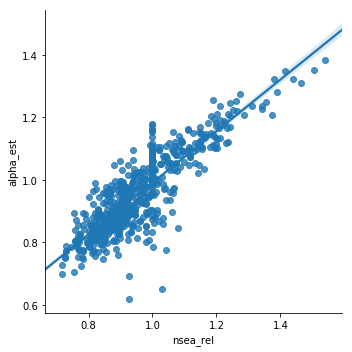

In [39]:
sns.lmplot(x = 'nsea_rel', y = 'alpha_est', data = data_df)

### Y Elasticity Estimation

$$\frac{Y(t_i)}{Y(t_j)} = \left(\frac{\alpha(t_j)}{\alpha(t_i)}\right)^{\frac{1}{\phi - 1}} * \left(\frac{p(t_i)}{p(t_j)}\right)^{\frac{1}{\phi - 1}}$$

In [40]:
# month1, month2 = 1, 2

# nsea_div = np.divide(data_df.query('month == @month1').sort_values(by = 'State FIPS')['net_sales_elc_all'], 
#           data_df.query('month == @month2').sort_values(by = 'State FIPS')['net_sales_elc_all'])

# nsea_rel_div = np.divide(data_df.query('month == @month1').sort_values(by = 'State FIPS')['nsea_rel'], 
#           data_df.query('month == @month2').sort_values(by = 'State FIPS')['nsea_rel'])

# nsea_dmd_div = np.divide(data_df.query('month == @month1').sort_values(by = 'State FIPS')['nsea_dmd'], 
#           data_df.query('month == @month2').sort_values(by = 'State FIPS')['nsea_dmd'])

# epa_div = np.divide(data_df.query('month == @month1').sort_values(by = 'State FIPS')['elc_price_all'], 
#           data_df.query('month == @month2').sort_values(by = 'State FIPS')['elc_price_all'])

# data_temp = pd.DataFrame([nsea_rel_div, nsea_div, epa_div]).transpose()
# data_temp['ln_nsea_rel'] = np.log(data_temp['nsea_rel'])
# #data_temp['ln_nsea_dmd'] = np.log(data_temp['nsea_dmd'])
# data_temp['ln_elc_price_all'] = np.log(data_temp['elc_price_all'])

In [41]:
data_temp = data_df.query('month == 1').groupby(['State FIPS']).first().reset_index()
data_temp = data_temp[['State FIPS', 'alpha_est']].rename(columns = {'alpha_est': 'alpha_est_m1'})

data_df = data_df.merge(data_temp, on = 'State FIPS')

data_df['alpha_est_rel'] = np.divide(data_df['alpha_est'], data_df['alpha_est_m1'])

In [42]:
data_df['rhs'] = np.divide(data_df['epa_rel'], data_df['alpha_est_rel'])

In [415]:
smf.ols('np.log(nsea_rel) ~ np.log(rhs)', data = data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(nsea_rel)   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     351.4
Date:                Mon, 06 Aug 2018   Prob (F-statistic):           1.71e-62
Time:                        14:08:15   Log-Likelihood:                 516.90
No. Observations:                 624   AIC:                            -1030.
Df Residuals:                     622   BIC:                            -1021.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0402      0.007      6.038      0.000       0.027       0.053
np.log(rhs)    -0.7005      0.037    -18.746      0.000      -0.774      -0.627
==============================================================================
Omnibus:                       69.549   Durbin-Watson:                   0.560
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.894
Skew:                           0.768   Prob(JB):                     1.67e-23
Kurtosis:                       4.294   Cond. No.                         8.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Coefficient on $np.log(rhs) = -0.7 \, \implies \, sigma = 0.7$

### X Elasticity Estimation

In [416]:
data_df.columns

Index(['State Name', 'month_name', 'net_sales_elc_all', 'month',
       'solar_avg_rad', 'State FIPS', 'Total_Area', 'Land_Area', 'Water_Area',
       'Water_Inland_Area', 'Water_Coastal_Area', 'Water_Great_Lakes_Area',
       'Water_Territorial_Area', 'Avg_Wind_Speed', 'Population', 'CDD', 'HDD',
       'rgdp', 'elc_price_all', 'elc_price_com', 'elc_price_ind',
       'elc_price_oth', 'elc_price_res', 'elc_price_trn', 'average_cost_coal',
       'average_cost_natural_gas', 'average_cost_oil', 'net_gen_all_all',
       'net_gen_all_biomass', 'net_gen_all_coal', 'net_gen_all_geothermal',
       'net_gen_all_natural_gas', 'net_gen_all_nuclear', 'net_gen_all_oil',
       'net_gen_all_solar', 'net_gen_all_wind', 'net_gen_all_hydro',
       'net_gen_elc_all', 'net_gen_elc_biomass', 'net_gen_elc_coal',
       'net_gen_elc_geothermal', 'net_gen_elc_natural_gas',
       'net_gen_elc_nuclear', 'net_gen_elc_oil', 'net_gen_elc_solar',
       'net_gen_elc_wind', 'net_gen_elc_hydro', 'Unit_coal',
 

In [417]:
#sns.lmplot(x = 'net_gen_elc_solar', y = 'Land_Area', data = data_df.query('net_gen_elc_solar > 0'))

In [418]:
res_solar = smf.ols('net_gen_elc_solar ~ solar_avg_rad + Land_Area', 
                    data = data_df.query('net_gen_elc_solar > 0 & solar_avg_rad > 0')).fit()
res_solar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      net_gen_elc_solar   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     48.70
Date:                Mon, 06 Aug 2018   Prob (F-statistic):           1.27e-19
Time:                        14:08:15   Log-Likelihood:                -2752.4
No. Observations:                 396   AIC:                             5511.
Df Residuals:                     393   BIC:                             5523.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -217.6279     41.487     -5.246      0.000    -299.191    -136.064
solar_avg_rad  4.896e+04   9815.817      4.988      0.000    2.97e+04    6.83e+04
Land_Area      5.119e-10   1.11e-10      4.596      0.000    2.93e-10    7.31e-10
==============================================================================
Omnibus:                      386.316   Durbin-Watson:                   0.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10202.628
Skew:                           4.332   Prob(JB):                         0.00
Kurtosis:                      26.308   Cond. No.                     1.58e+14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+14. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

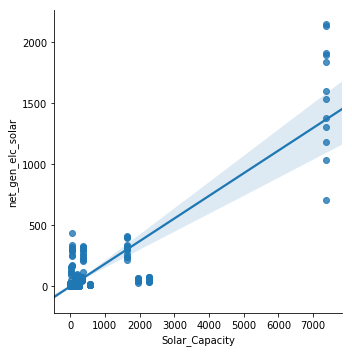

In [419]:
sns.lmplot(x = 'Solar_Capacity', y = 'net_gen_elc_solar', data = data_df)

In [420]:
smf.ols('net_gen_elc_coal~ con_for_gen_coal-1', data = data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       net_gen_elc_coal   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                 1.565e+04
Date:                Mon, 06 Aug 2018   Prob (F-statistic):               0.00
Time:                        14:08:16   Log-Likelihood:                -4895.4
No. Observations:                 624   AIC:                             9793.
Df Residuals:                     623   BIC:                             9797.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
con_for_gen_coal     1.7579      0.014    125.087      0.000       1.730       1.786
==============================================================================
Omnibus:                      156.174   Durbin-Watson:                   0.198
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1555.162
Skew:                          -0.802   Prob(JB):                         0.00
Kurtosis:                      10.566   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$$MRS_{12} =  \frac{ \int_0^1 \alpha(t) \, Y(t)^{\phi - 1} \, \xi_1(t) \, dt }{ \int_0^1 \alpha(t) \, Y(t)^{\phi - 1} \, \xi_2(t) \, dt }$$

In [421]:
t = 1
sigma = 0.7
phi = (sigma-1)/sigma
# cite 15%
mrs_eq_top = sin_f_fitted(t) * (data_df['net_sales_elc_all']**(phi-1)) * (30*0.15 * data_df['solar_avg_rad'])
mrs_eq_bot = sin_f_fitted(t) * (data_df['net_sales_elc_all']**(phi-1)) * 1.7579

In [422]:
data_df['ln_mrs_solar_coal'] = np.log(mrs_eq_top/mrs_eq_bot+1)
data_df['ln_coal_solar'] = np.log(1 + data_df.apply(
    lambda row: row.con_for_gen_coal / row.Solar_Capacity, axis = 1))

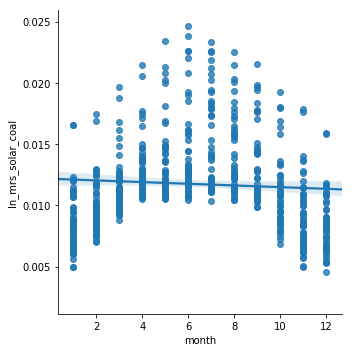

In [423]:
sns.lmplot(x = 'month', y = 'ln_mrs_solar_coal', data = data_df)

In [424]:
smf.ols('ln_coal_solar ~ ln_mrs_solar_coal', data = data_df.query('month > 0')).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ln_coal_solar   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.078
Date:                Mon, 06 Aug 2018   Prob (F-statistic):             0.0440
Time:                        14:08:16   Log-Likelihood:                -1284.9
No. Observations:                 492   AIC:                             2574.
Df Residuals:                     490   BIC:                             2582.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.6275      0.466      9.928      0.000       3.712       5.543
ln_mrs_solar_coal   -75.2348     37.255     -2.019      0.044    -148.435      -2.035
==============================================================================
Omnibus:                      128.352   Durbin-Watson:                   0.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.583
Skew:                           0.455   Prob(JB):                     4.19e-09
Kurtosis:                       1.973   Cond. No.                         250.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [425]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [426]:
def f(m):
    sns.lmplot(y = 'ln_coal_solar', x = 'ln_mrs_solar_coal', data = data_df.query('month == @m'))
    #plt.scatter(x = 'ln_coal_solar', y = 'ln_mrs_solar_coal',  c = 'solar_avg_rad', data = data_df.query('month == @m'))

In [427]:
interact(f, m = widgets.IntSlider(min=1,max=12,step=1,value=6))

interactive(children=(IntSlider(value=6, description='m', max=12, min=1), Output()), _dom_classes=('widget-int…

<function __main__.f(m)>

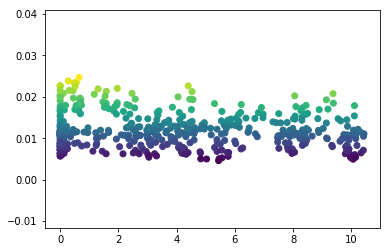

In [344]:
plt.scatter(x = 'ln_coal_solar', y = 'ln_mrs_solar_coal',  c = 'solar_avg_rad', data = data_df)